## notebook to query vespa app
1. remeber to connect to GDRIVE


## Installations and imports


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%pip install pyvespa git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hzpe46r3
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-hzpe46r3
     |████████████████████████████████| 76 kB 3.0 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 1.1 MB 18.5 MB/s 
     |████████████████████████████████| 4.0 MB 54.2 MB/s 
     |████████████████████████████████| 146 kB 66.5 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 271 kB 54.9 MB/s 
     |████████████████████████████████| 144 kB 52.2 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369387 sha256=1b1ad5e55a71f872dbfc575f745ec371a63cf4ce8267929bf575924ec0a66dfe
  Stored in directory: /tmp/pip-ephem-wheel-cache-lr0yf_is/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:

from vespa.application import Vespa
from vespa.query import QueryModel

from google.colab.patches import cv2_imshow

import importlib, sys, os
sys.path.append("/content/drive/MyDrive/AI/Artgrid Search/poc_code/")

os.environ["AL_ENV"] = "dev"

In [ ]:
from colab_util import hconcat_resize_min
from vespa_utils import get_vespa_app, display_results, ClipRetrival, get_unique_story_hits
from embedding import create_vespa_query_body_function, TextProcessor

In [ ]:
# app = get_vespa_app()
# body = {"yql": "select * from sources * where true;"}
# #check connection and number of documents
# app.query(body).json.get('root').get('fields')


number_documents_indexed: 423115


In [ ]:
app = get_vespa_app(
      # base_path="/content/drive/MyDrive/AI/Artgrid Search/poc_code/sec/clip_app_sec/",
      base_path="/content/drive/MyDrive/AI/Artgrid Search/poc_code/sec/artgrid_app_artgrid_demo/",
    # endpoint="https://image-search-container.artgrid-clip-search.joseph-app.artgrid-demo.aws-us-east-1c.dev.z.vespa-app.cloud/"
    endpoint="https://joseph.footage.artgrid-demo.aws-us-east-1c.dev.z.vespa-app.cloud/"
)
# body = {"yql": "select * from sources image_search where true;"}
#check connection and number of documents
# app2.query(body).json.get('root').get('fields')

number_documents_indexed: 203772


In [ ]:
clip_models = ['ViT-B/32']

In [ ]:
sub_list_query_text=(['Camera', 'Climate', 'Clouds', 'Computer', 'Earth', 'Free', 'Future', 'Horror', 'House', 'New', 'News', 'People', 'Planet', 'Rain', 'Science', 'Social', 'Thinking', 'Time', 'Woman', 'Art', 'Background', 'Blood', 'Brain', 'Cars', 'China', 'Clock', 'Dancing', 'Desert', 'Driving', 'Dubai', 'Energy', 'Explosion', 'Farm', 'Football', 'Galaxy', 'Gaming', 'India', 'Internet', 'Jesus', 'Korea', 'Man', 'Police', 'Road', 'Robot', 'Run', 'Sad', 'School', 'Sex', 'Shopping', 'Sky', 'Sun', 'Tech', 'Train', 'Wedding', 'World', 'Background', 'Clock', 'Desert', 'Farm', 'Internet', 'Road', 'Run', 'Sky', 'Sun', 'Black Children', 'Covid Shot', 'Internet People', 'Light Film', 'Love Men', 'Morning Day', 'Muscles Male', 'Portrait Medium Male', 'Run Up', 'Urban & City Medical & Health'])

# Run Query
* update "query" string and the result will be dispalyed
* upate "hits" for number of results to be retrned (not exact since we are only displaying 1 result per StoryID)

In [ ]:
# common misspelling based on  
misspelings=["wether", "Assasination", "Carribean" ,"cemetary","category" , "driving in the dessert"]
descriptive=["man on the moon","child palying with lego", "man excited to see his daughter"] #"drinking beer in a tent"
slang=["420", "geek", "bro","gona kick your ass"]
# "calender"
failed = ["perplexed situation"]

In [ ]:
import json
from dataclasses import dataclass
from typing import List

@dataclass
class RecallDocs:
    query_id: int
    recall_docs: List[int]

label_data_json="/content/drive/MyDrive/AI/Artgrid Search/poc_code/recall_docs.json"
label_data = json.load(open(label_data_json, "r"))
def reformat_recall_docs(label_data: list):
    recall_docs = []
    for ld in label_data:
        list_id = []
        for docs in ld["relevant_docs"]:
            for k, vi in docs.items():
                if k == "id":
                    list_id.append(vi)
        recall_docs.append(RecallDocs(ld["query_id"], list_id))
    return recall_docs
def reformat_get_hits(df):
  df['clip_id']=df['doc_id'].str.split("::").str[1]
  df = (df.set_index('clip_id'))
  return df
  
sub_label_data=[d for d in label_data if d['query'] in sub_list_query_text]

recall_docs = reformat_recall_docs(sub_label_data)

In [ ]:
query_id=3
query_data=sub_label_data[query_id]
query=query_data["query"]  #"Camera"

# query_mode="image" # Which embeddings to query? options "image" or "tags"

query_model_image = [QueryModel(
    name=model_name, 
    body_function=create_vespa_query_body_function(model_name, query_mode="image")
) for model_name in clip_models]

query_model_tags = [QueryModel(
    name=model_name, 
    body_function=create_vespa_query_body_function(model_name, query_mode="tags")
) for model_name in clip_models] 

NUM_HITS=20
query_result_image = app.query(query=query, query_model=query_model_image[0], hits = NUM_HITS)
query_result_tags = app.query(query=query, query_model=query_model_tags[0], hits = NUM_HITS)

print(query)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 192MiB/s]


Computer


In [ ]:
from vespa.evaluation import NormalizedDiscountedCumulativeGain
import pandas as pd

eval_metrics = [    NormalizedDiscountedCumulativeGain(at=20),]
query_id=8
query_data=sub_label_data[query_id]
query=query_data["query"]  #"Camera"
query="an image of a house"
_recall_docs = recall_docs[query_id].recall_docs
HITS=len(_recall_docs)

query_evaluation = app.evaluate_query(
    eval_metrics = eval_metrics,
    query_model = query_model_image[0],
    query_id = query_data["query_id"],
    query = query_data["query"],
    id_field = "id",
    relevant_docs = query_data["relevant_docs"],
    default_score = 0, 
    # recall=("id", _recall_docs),
    hits=HITS
)
print(f'{query}')
print(query_evaluation)

df_relevant_docs = pd.DataFrame(query_data["relevant_docs"])
df_relevant_docs=(df_relevant_docs.rename(columns={'id':'clip_id'})
                    .set_index('clip_id')
)
query_recall_res =app.query(query=query, 
          query_model=query_model_image[0], 
          hits = len(_recall_docs),
          recall=("id", _recall_docs),
          )
df_query_recall_hits=reformat_get_hits(query_recall_res.get_hits())
df_query_recall_hits.head(11)
# df_join_res = df_query_recall_hits.join(df_relevant_docs, how='outer', rsuffix='_hit').sort_values(by='rank')
# df_join_res

an image of a house
{'model': 'ViT-B/32', 'query_id': 25, 'ndcg_20': 0.0}


qid                        doc_id     score  rank
clip_id                                                   
354924     0  id:artgrid-demo:clip::354924  0.452910     0
93136      0   id:artgrid-demo:clip::93136  0.452098     1
32698      0   id:artgrid-demo:clip::32698  0.452021     2
44244      0   id:artgrid-demo:clip::44244  0.450034     3
43681      0   id:artgrid-demo:clip::43681  0.449701     4
362198     0  id:artgrid-demo:clip::362198  0.449552     5
238102     0  id:artgrid-demo:clip::238102  0.448856     6
44695      0   id:artgrid-demo:clip::44695  0.448286     7
197420     0  id:artgrid-demo:clip::197420  0.447919     8
47021      0   id:artgrid-demo:clip::47021  0.447667     9
55436      0   id:artgrid-demo:clip::55436  0.447038    10

In [ ]:
df_query_recall_hits.join(df_relevant_docs, how='outer', rsuffix='_hit').sort_values(by='rank')

qid                        doc_id     score  rank  score_hit
clip_id                                                              
354924     0  id:artgrid-demo:clip::354924  0.452910     0          3
93136      0   id:artgrid-demo:clip::93136  0.452098     1          3
32698      0   id:artgrid-demo:clip::32698  0.452021     2          2
44244      0   id:artgrid-demo:clip::44244  0.450034     3          1
43681      0   id:artgrid-demo:clip::43681  0.449701     4          2
362198     0  id:artgrid-demo:clip::362198  0.449552     5          3
238102     0  id:artgrid-demo:clip::238102  0.448856     6          1
44695      0   id:artgrid-demo:clip::44695  0.448286     7          2
197420     0  id:artgrid-demo:clip::197420  0.447919     8          2
47021      0   id:artgrid-demo:clip::47021  0.447667     9          1
55436      0   id:artgrid-demo:clip::55436  0.447038    10          3
238372     0  id:artgrid-demo:clip::238372  0.445165    11          1
197536     0  id:artgrid-demo:clip::197536  0.445099    12          0
47027      0   id:artgrid-demo:clip::47027  0.444965    13          2
46543      0   id:artgrid-demo:clip::46543  0.444174    14          1
47985      0   id:artgrid-demo:clip::47985  0.443793    15          0
180727     0  id:artgrid-demo:clip::180727  0.443709    16          1
39750      0   id:artgrid-demo:clip::39750  0.443498    17          2
156037     0  id:artgrid-demo:clip::156037  0.443334    18          2
58352      0   id:artgrid-demo:clip::58352  0.443181    19          2
349600     0  id:artgrid-demo:clip::349600  0.443060    20          0
184474     0  id:artgrid-demo:clip::184474  0.442914    21          0
200116     0  id:artgrid-demo:clip::200116  0.442747    22          0
335292     0  id:artgrid-demo:clip::335292  0.442520    23          0
66687      0   id:artgrid-demo:clip::66687  0.442117    24          0
22307      0   id:artgrid-demo:clip::22307  0.441804    25          0
49260      0   id:artgrid-demo:clip::49260  0.441536    26          1
22434      0   id:artgrid-demo:clip::22434  0.441174    27          1
48971      0   id:artgrid-demo:clip::48971  0.441160    28          1
221535     0  id:artgrid-demo:clip::221535  0.440490    29          1
235937     0  id:artgrid-demo:clip::235937  0.440481    30          0
208794     0  id:artgrid-demo:clip::208794  0.438665    31          1
68361      0   id:artgrid-demo:clip::68361  0.438509    32          0
145356     0  id:artgrid-demo:clip::145356  0.437625    33          0
32054      0   id:artgrid-demo:clip::32054  0.437545    34          1

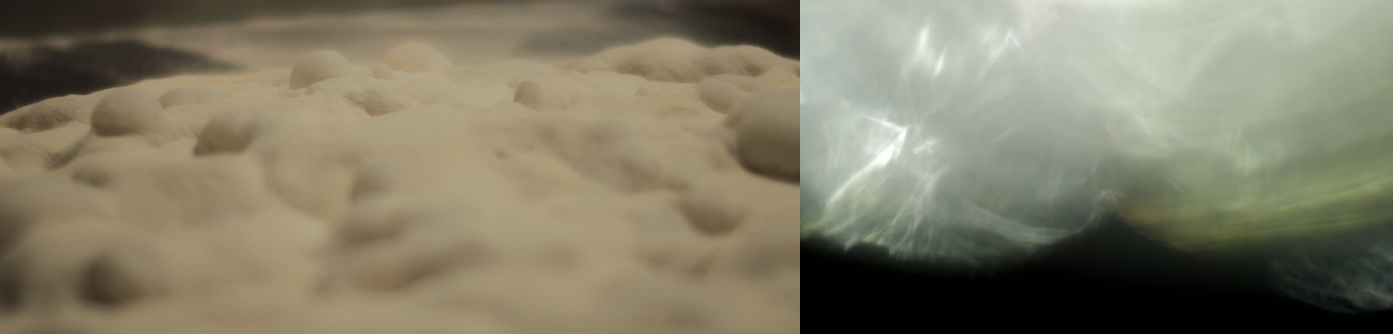

clipID:261004, relevance:0.4595766638446307, storyid:20495 
tags: clip_id
261004    al-taglio al-trancio european ingridient pizza...
Name: tags, dtype: object
preview: clip_id
261004    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:152342, relevance:0.0, storyid:16817 
tags: clip_id
152342    light-leak bright effect flare background shin...
Name: tags, dtype: object
preview: clip_id
152342    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


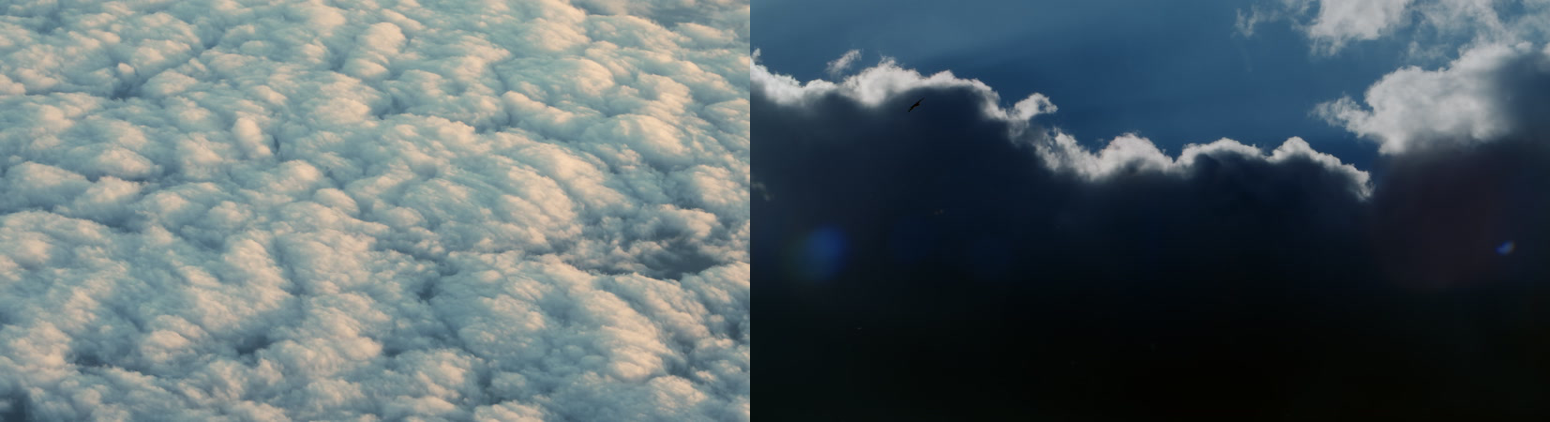

clipID:262807, relevance:0.4571553926279586, storyid:20556 
tags: clip_id
262807    altocumulus cloudscape on-the-move above aerop...
Name: tags, dtype: object
preview: clip_id
262807    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:164178, relevance:0.0, storyid:17272 
tags: clip_id
164178    eagle hunting flying nature outdoors cloudy an...
Name: tags, dtype: object
preview: clip_id
164178    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


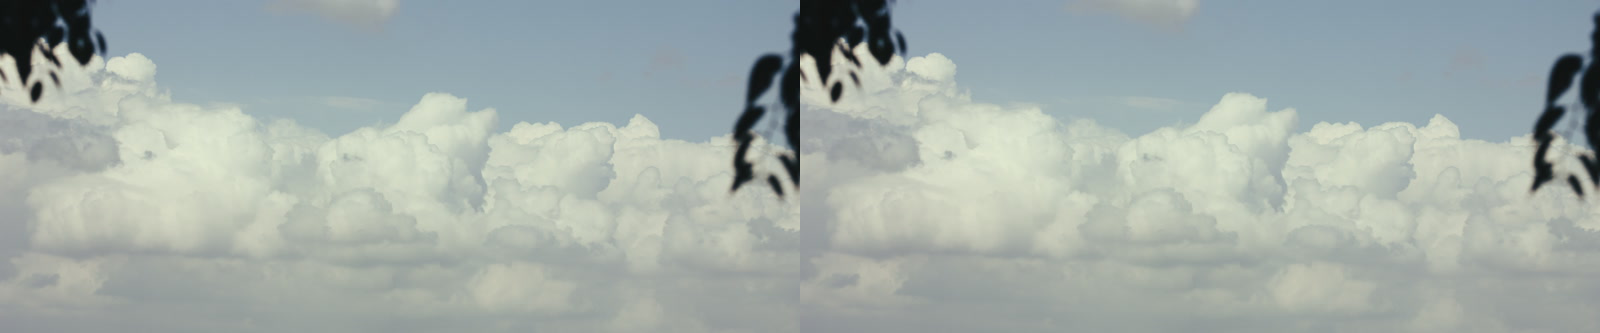

clipID:24149, relevance:0.45706564879799966, storyid:11067 
tags: clip_id
24149    fluffy wind breeze blue-sky day-light silhouet...
Name: tags, dtype: object
preview: clip_id
24149    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:24149, relevance:0.0, storyid:11067 
tags: clip_id
24149    fluffy wind breeze blue-sky day-light silhouet...
Name: tags, dtype: object
preview: clip_id
24149    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


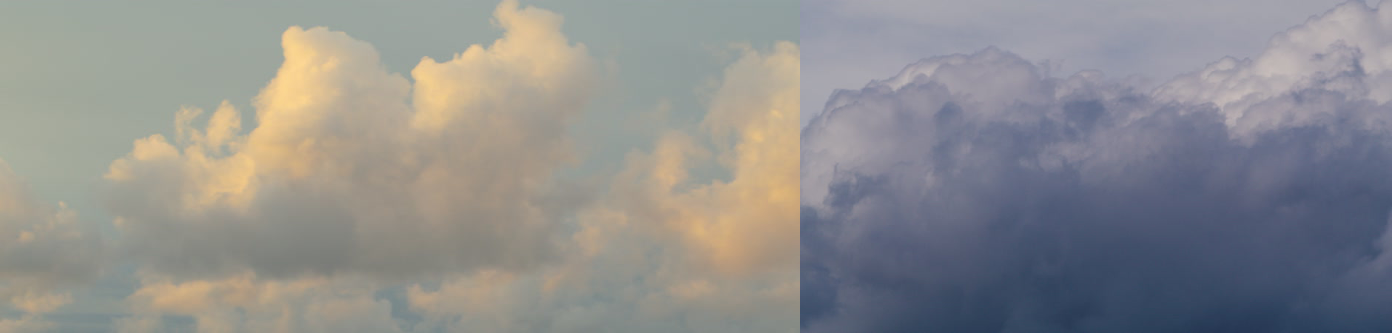

clipID:360129, relevance:0.4566604225575122, storyid:23579 
tags: clip_id
360129    clouds cloudy sky
Name: tags, dtype: object
preview: clip_id
360129    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:178687, relevance:0.0, storyid:17797 
tags: clip_id
178687    sky bright air wind formations movement weathe...
Name: tags, dtype: object
preview: clip_id
178687    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


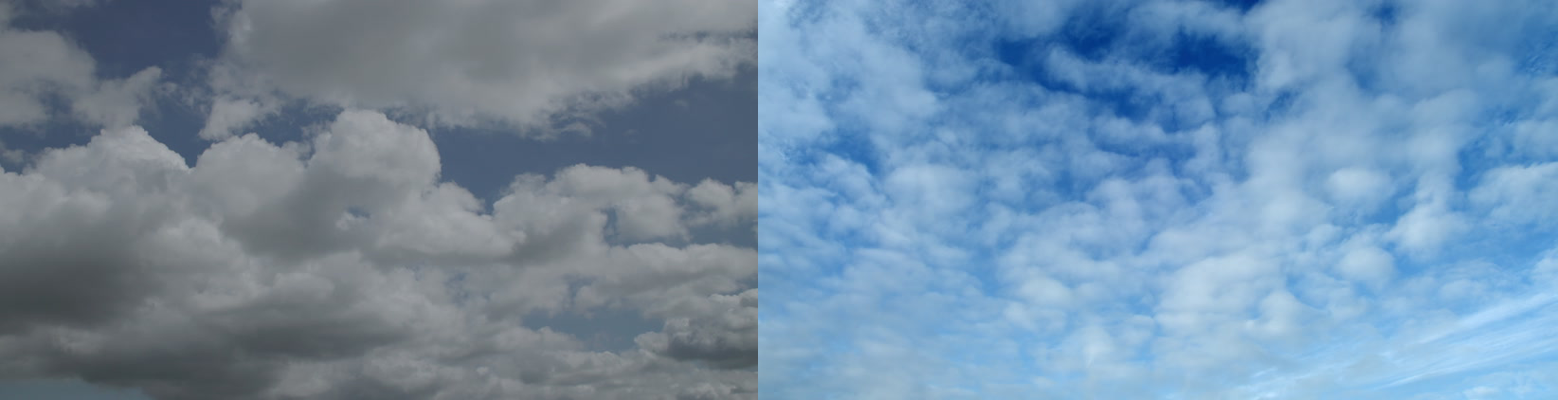

clipID:323241, relevance:0.456630088528314, storyid:22394 
tags: clip_id
323241    daylight stormy clouds sky cloudy
Name: tags, dtype: object
preview: clip_id
323241    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:38166, relevance:0.0, storyid:11531 
tags: clip_id
38166    clouds motion blue clear dry heaven cloudy whi...
Name: tags, dtype: object
preview: clip_id
38166    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


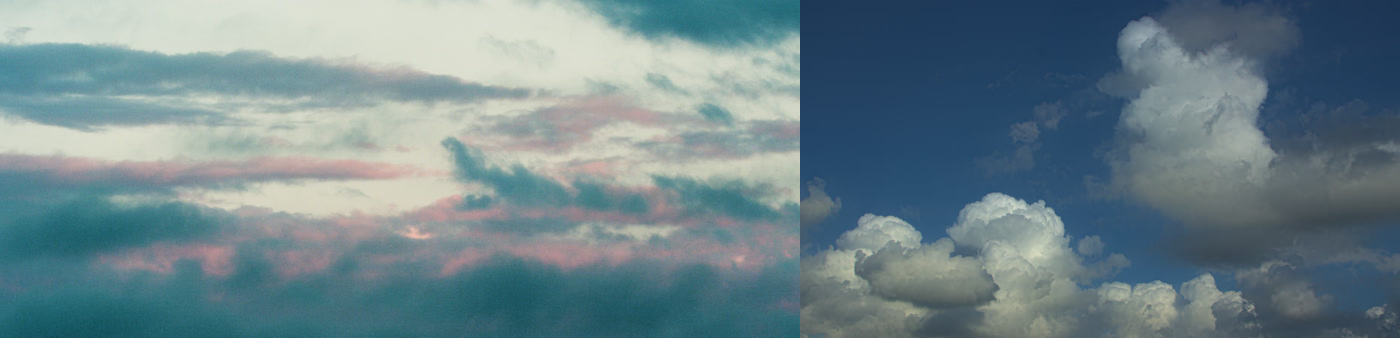

clipID:288299, relevance:0.456547200367189, storyid:21356 
tags: clip_id
288299    sunset sky low-cloud dusk dawn sunrise clouds
Name: tags, dtype: object
preview: clip_id
288299    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:41851, relevance:0.0, storyid:11696 
tags: clip_id
41851    clouds nature blue timelapse outdoor horizon c...
Name: tags, dtype: object
preview: clip_id
41851    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


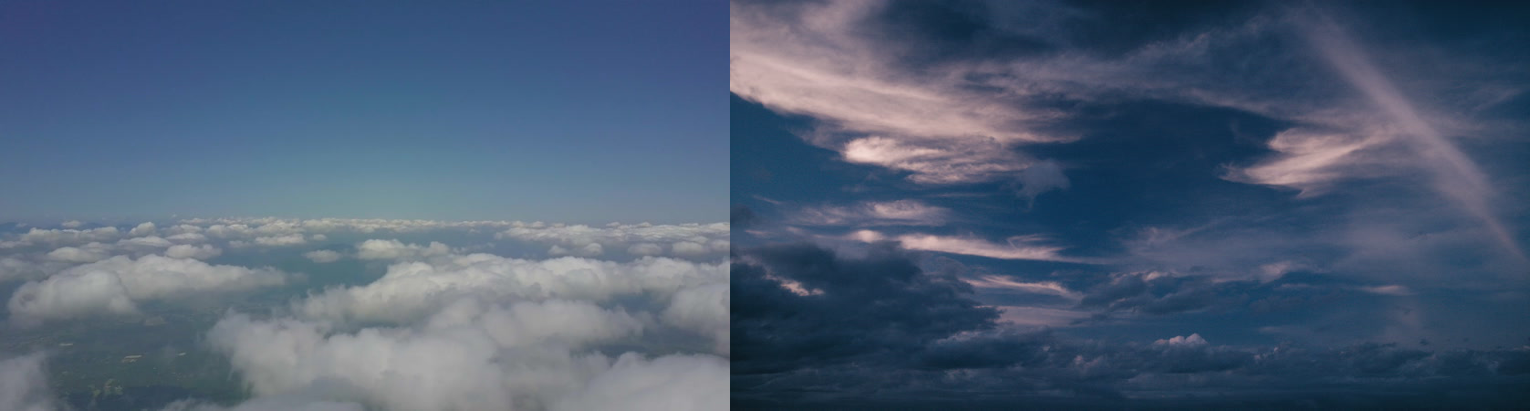

clipID:47183, relevance:0.4565240846785968, storyid:11947 
tags: clip_id
47183    clouds mountain altitude volcano high climate ...
Name: tags, dtype: object
preview: clip_id
47183    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:42688, relevance:0.0, storyid:11720 
tags: clip_id
42688    sky wind windy sundown scenic view rain-clouds...
Name: tags, dtype: object
preview: clip_id
42688    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


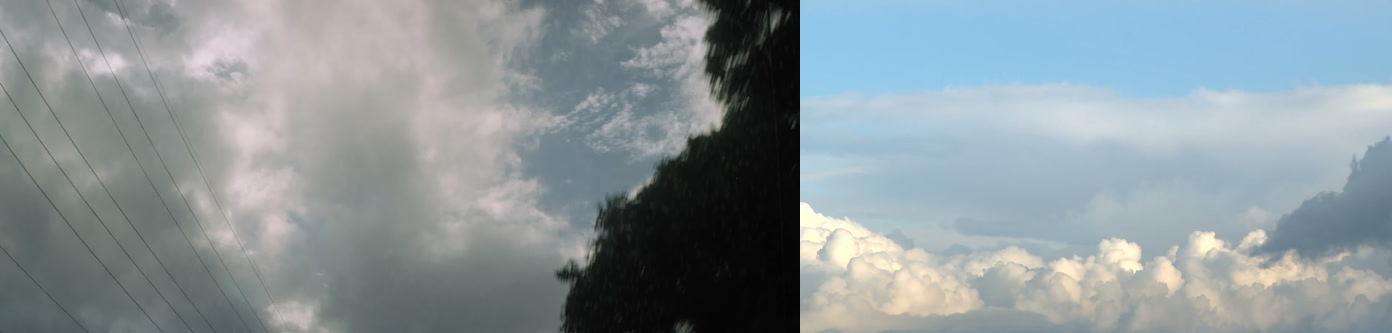

clipID:44263, relevance:0.45642575496570276, storyid:11779 
tags: clip_id
44263    wires blue sky cloudy clouds trees telephone n...
Name: tags, dtype: object
preview: clip_id
44263    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:43085, relevance:0.0, storyid:11732 
tags: clip_id
43085    puffy white blown sky light cloudy blue sunlit...
Name: tags, dtype: object
preview: clip_id
43085    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


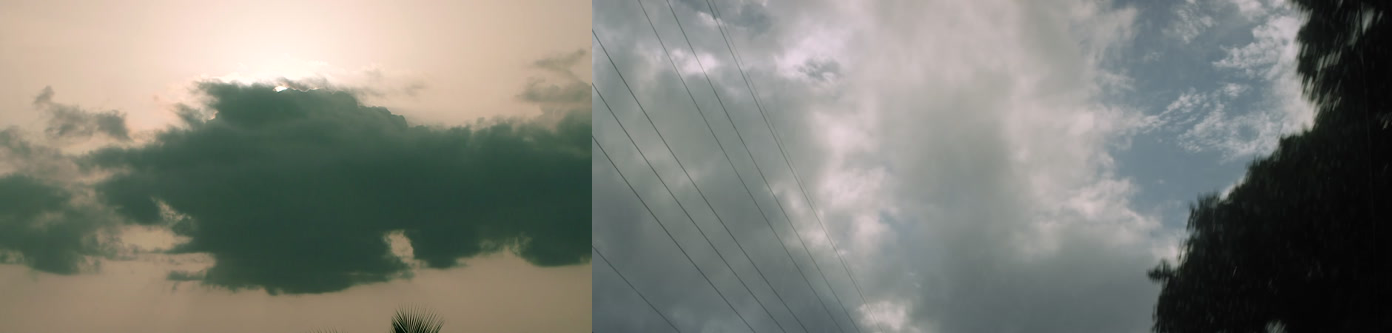

clipID:46540, relevance:0.456232805515764, storyid:11888 
tags: clip_id
46540    clouds sun bright green leaves celestial weath...
Name: tags, dtype: object
preview: clip_id
46540    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:44263, relevance:0.0, storyid:11779 
tags: clip_id
44263    wires blue sky cloudy clouds trees telephone n...
Name: tags, dtype: object
preview: clip_id
44263    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


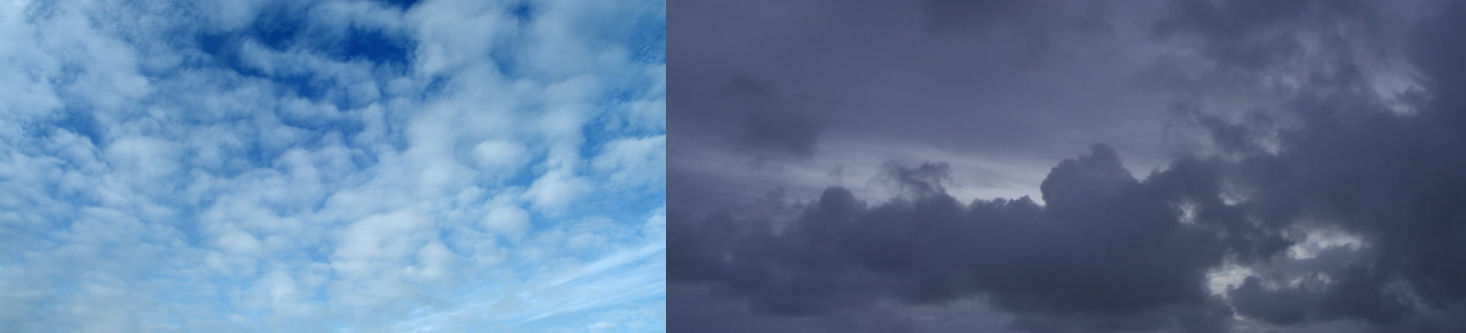

clipID:38166, relevance:0.45611347977989497, storyid:11531 
tags: clip_id
38166    clouds motion blue clear dry heaven cloudy whi...
Name: tags, dtype: object
preview: clip_id
38166    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:46397, relevance:0.0, storyid:11870 
tags: clip_id
46397    sky grey heavy dark late celestial wilderness ...
Name: tags, dtype: object
preview: clip_id
46397    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


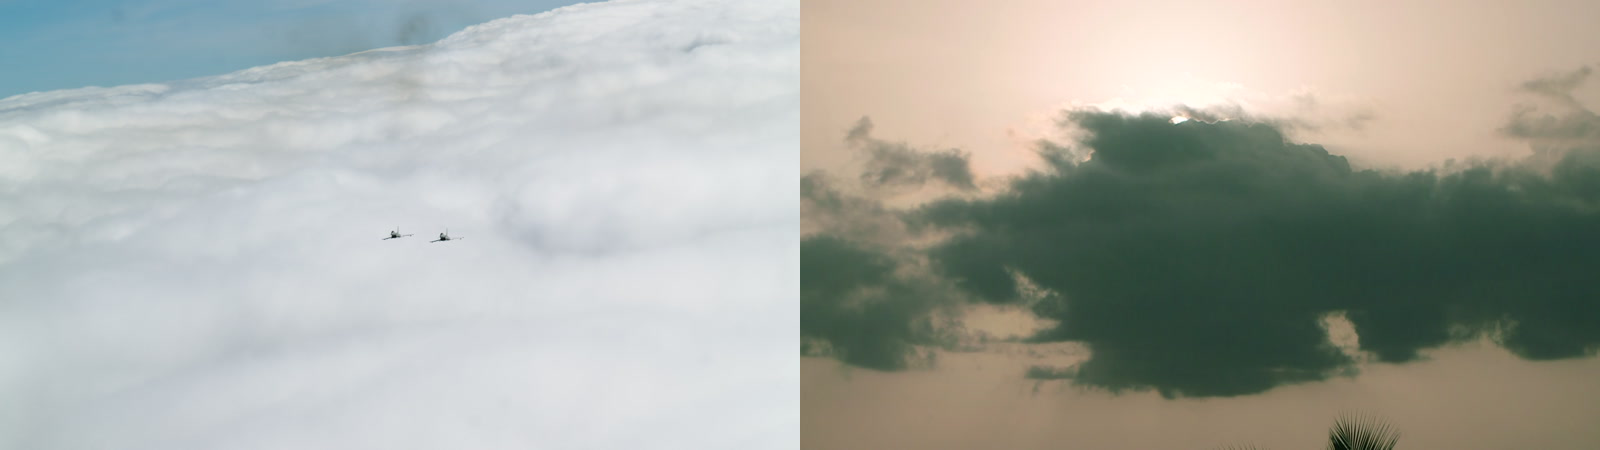

clipID:299881, relevance:0.4560950750197528, storyid:21734 
tags: clip_id
299881    fighter-aircraft fighter-plane fighter-jet clo...
Name: tags, dtype: object
preview: clip_id
299881    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:46540, relevance:0.0, storyid:11888 
tags: clip_id
46540    clouds sun bright green leaves celestial weath...
Name: tags, dtype: object
preview: clip_id
46540    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


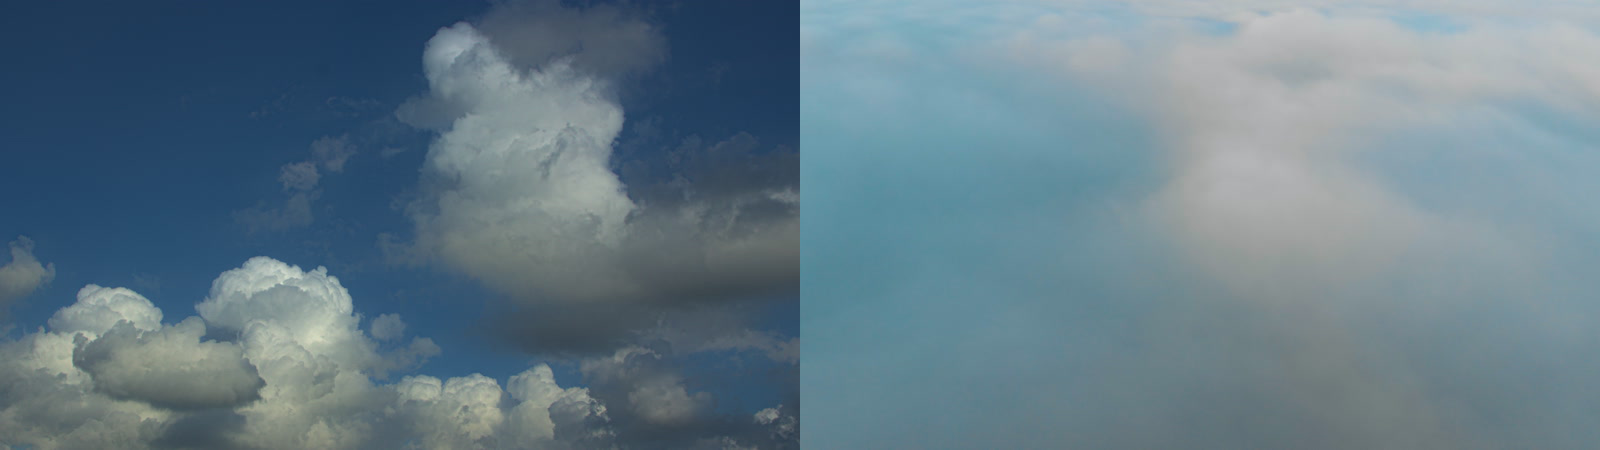

clipID:41851, relevance:0.45609295397636773, storyid:11696 
tags: clip_id
41851    clouds nature blue timelapse outdoor horizon c...
Name: tags, dtype: object
preview: clip_id
41851    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:46691, relevance:0.0, storyid:11902 
tags: clip_id
46691    mountains sky blue mist fog drone sunny sun al...
Name: tags, dtype: object
preview: clip_id
46691    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


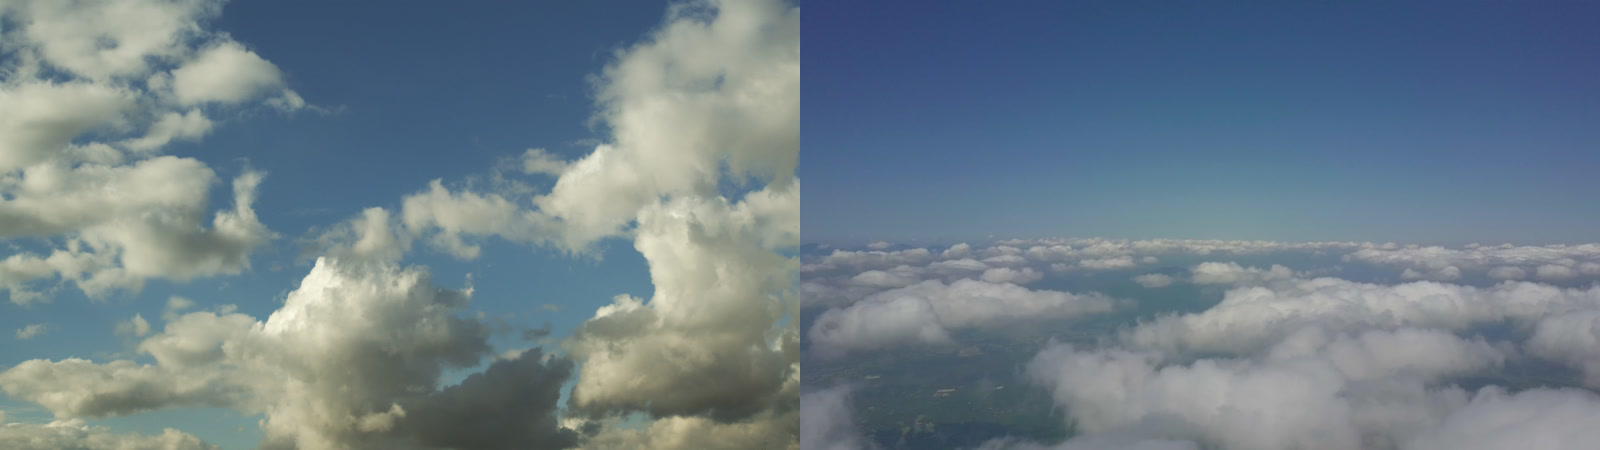

clipID:237100, relevance:0.4560683671927796, storyid:19700 
tags: clip_id
237100    cloudscape dream adventure aerial airplane cli...
Name: tags, dtype: object
preview: clip_id
237100    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:47183, relevance:0.0, storyid:11947 
tags: clip_id
47183    clouds mountain altitude volcano high climate ...
Name: tags, dtype: object
preview: clip_id
47183    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


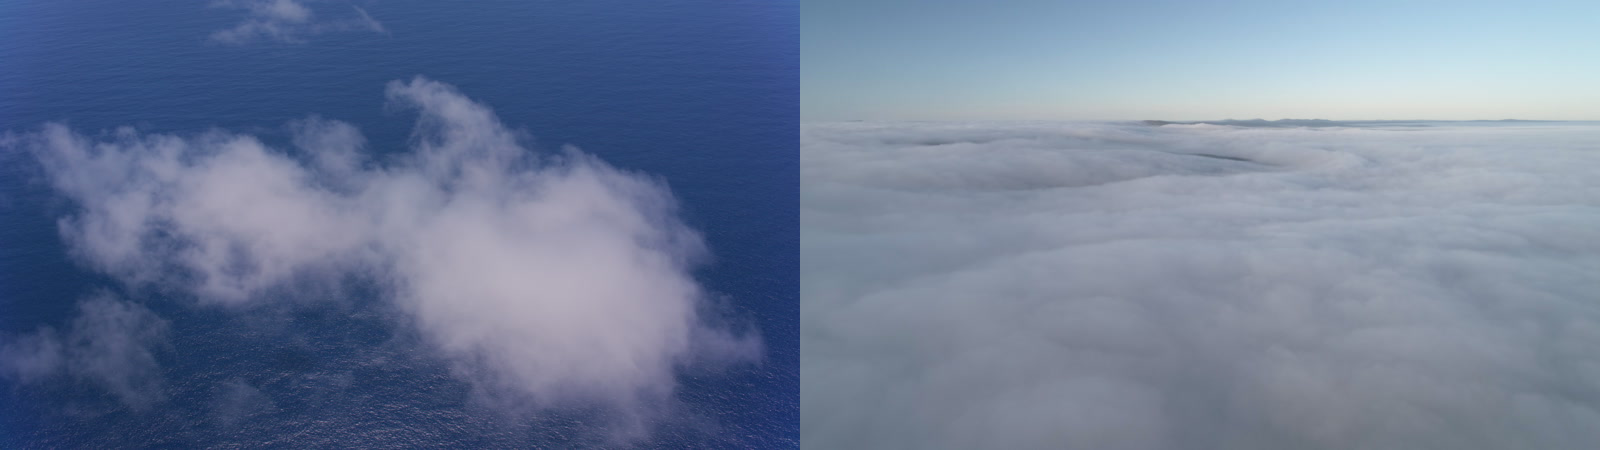

clipID:300885, relevance:0.45605630957279497, storyid:21773 
tags: clip_id
300885    sea drone sky above clouds hawaii kauai cloud
Name: tags, dtype: object
preview: clip_id
300885    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object
clipID:59931, relevance:0.0, storyid:12786 
tags: clip_id
59931    serene clouds cloud peaceful flying horizon sk...
Name: tags, dtype: object
preview: clip_id
59931    https://cms-public.cdn.artgrid.io/content/artg...
Name: hdPreviewFile, dtype: object


In [ ]:
qrl= [get_unique_story_hits(query_result_image), 
      get_unique_story_hits(query_result_tags)]

clip1 = ClipRetrival()
clip2 = ClipRetrival()
for h1,h2 in zip(qrl[0], qrl[1]):
    clip1.set_hit(h1)
    clip2.set_hit(h2)
    final_frame = hconcat_resize_min([clip1.get_image(),clip2.get_image()])
    cv2_imshow(final_frame)
    clip1.get_h_metadata()
    clip2.get_h_metadata()

In [ ]:
# query_result_image = app.query(query=query, query_model=query_model_image[0], hits = NUM_HITS)
query_result_tags.get_hits()
# h =query_result_tags.hits[0]
# h

In [ ]:
im_list =[img1, img2]
def hconcat_resize_min(im_list, interpolation=cv.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                      for im in im_list]
    return cv.hconcat(im_list_resize)
im_h_resize = hconcat_resize_min(im_list)
cv2_imshow(im_h_resize)


In [ ]:
body = {
    "yql": 'select * from sources * where id =18428;',
    "hits": "92",
} # . 18428. 16599
r3 = app.query(body)
r3.json

In [ ]:
body = {
    "yql": 'select vit_b_32_image from sources * where id ="18428";',
    "hits": "3",
} # . 18428. 16599 8e3f7abc2891fc42ff3ce6d6
r3 = app.query(body)
r3.json

In [ ]:
model_name=clip_models[0]
image_field_name="vit_b_32_image"
text_field_name = "vit_b_32_text"
query="Flower"
ranking_name="vit_b_32_similarity_tags"
text_processor=TextProcessor(model_name=model_name)
body ={
        "yql": 'select * from sources * where ([{{"targetNumHits":100}}]nearestNeighbor({},{}));'.format(
            image_field_name, text_field_name
        ),
        "hits": 100,
        "ranking.features.query({})".format(text_field_name): text_processor.embed(
            query
        ),
        "ranking.profile": ranking_name,
        "timeout": 10,
    }


In [ ]:
r3 = app.query(body)
r3.get_hits()